# EnKF for pressure time evolution in two reservoirs at Ambrym

This Jupyter Notebook is used to run the EnKF procedure and produce Figures 2 and 3 from "Two distinct magma storage regions at Ambrym volcano detected by satellite geodesy", submitted to Geophysical Research Letters by TL Shreve, Y Zhan, H Le Mevel, D Roman, and Y Moussallam. 

In [ ]:
import sys
import os
# path to the pyproj library
#os.environ['PROJ_LIB']=r'.../pyproj/proj_dir/share/proj'
#os.environ['PROJ_LIB']=r'/Users/yanzhan/miniconda3/lib/python3.9/site-packages/pyproj/proj_dir/share/proj'

# python modules 
import time
from datetime import datetime
from multiprocessing import Pool
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm

import rioxarray as rx
import pyproj
from pyproj import Transformer
from pyproj import CRS
from pyproj.aoi import AreaOfInterest
from pyproj.database import query_utm_crs_info

import h5py
import pyvista as pv
import panel as pn
import pickle
from cmcrameri import cm as cmcr

# custom fuctions
from util.prep.insar_ts import read_hd5_tara
from util.prep.dem import read_geotiff
from util.analytical.yang_ex import yang_disp, yang_disp_pool
from util.analytical.volc_model import mogi_vol_pool, mogi_vol
from util.enkf.enkf import EnKF


# number of CPU for simulation
PROCESSES = 4
# set pyvista plot environment
pv.set_jupyter_backend('panel')

### Location of Ambrym

In [2]:
# projection transform (for Ambrym)
LL2UTM = Transformer.from_crs("epsg:4326", "epsg:32759")

# Ambrym volcano location
lon_Ambrym = 168.12
lat_Ambrym = -16.25
volcx, volcy = LL2UTM.transform(lat_Ambrym,lon_Ambrym)

# define the boundary
lon_lim = [167.9,168.35]
lat_lim = [-16.4,-16.05]
# reference point
ref_lon_asc = 168.03905
ref_lat_asc = -16.226244
ref_lon_des = 168.04037
ref_lat_des = -16.224562
# UTM of the reference point
ref_utmx_asc, ref_utmy_asc = LL2UTM.transform(ref_lat_asc,ref_lon_asc)
ref_utmx_des, ref_utmy_des = LL2UTM.transform(ref_lat_des,ref_lon_des)
# Model X, Y of the reference point
ref_x_asc = ref_utmx_asc - volcx
ref_y_asc = ref_utmy_asc - volcy
ref_x_des = ref_utmx_des - volcx
ref_y_des = ref_utmy_des - volcy


### Read InSAR data

In [3]:
### Data prepare
# read InSAR timeseries data
# descending
data_des = 'data/20190203-20211213_TS_S1_desc.h5'
geom_des = 'data/TS_S1_desc_geometryRadar.h5'
pv_des = read_hd5_tara(data_des,geom_des,lon_lim,lat_lim,
                       dsize=200,volcx=volcx,volcy=volcy)
# ascending
data_asc = 'data/20190205-20220126_TS_S1_asc.h5'
geom_asc = 'data/TS_S1_asc_geometryRadar.h5'
pv_asc = read_hd5_tara(data_asc,geom_asc,lon_lim,lat_lim,
                       dsize=200,volcx=volcx,volcy=volcy)

# store ascending and descending together for
# easiler plot
track_label = ['Ascending','Descending']
pv_AD = [pv_asc,pv_des]
ref_x = [ref_x_asc, ref_x_des]
ref_y = [ref_y_asc, ref_y_des]

# construct uniform time series
time_all = np.hstack([pv_asc['time'][0:],
                      pv_des['time'][0:]])
time_all = np.sort(time_all)

# maximum of the data
dat_max_all = []
for track in [0,1]:
    dat_max_all.append(np.nanmax(pv_AD[track]\
                                 ['unif_point']\
                                 ['t{}'.format(len(pv_AD[track]['t_str'])-1)]))

# allocate the pv for plotting data
mod_asc = pv_asc['unif_point'].copy()
mod_asc.clear_data()
mod_des = pv_des['unif_point'].copy()
mod_des.clear_data()
mod_AD = [mod_asc, mod_des]

### Read topography data for visualization

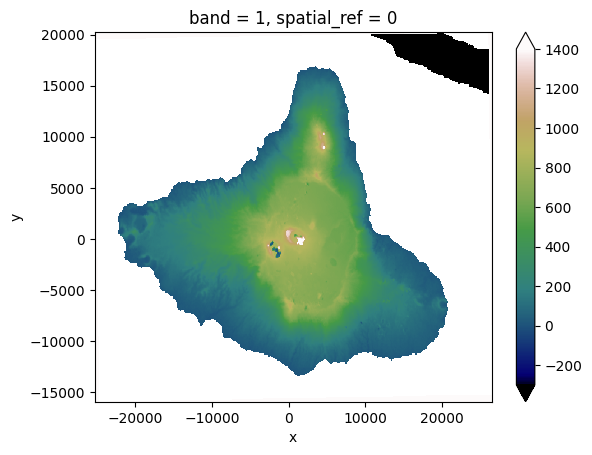

In [4]:
# read topography
topo = rx.open_rasterio('data/Ambrym_masked.tif')
# add projection info
topo = topo.rio.write_crs("EPSG:4326")
# topo max
zmax = int(topo.sel(band=1).max())

# convert to UTM
topo_utm = topo.rio.reproject("epsg:32759")

# recenter the topo
topo_utm = topo_utm.assign_coords(x=topo_utm.x-volcx,y=topo_utm.y-volcy)
topo_utm.sel(band=1).plot.imshow(cmap='gist_earth',vmin=-300,vmax=1400)

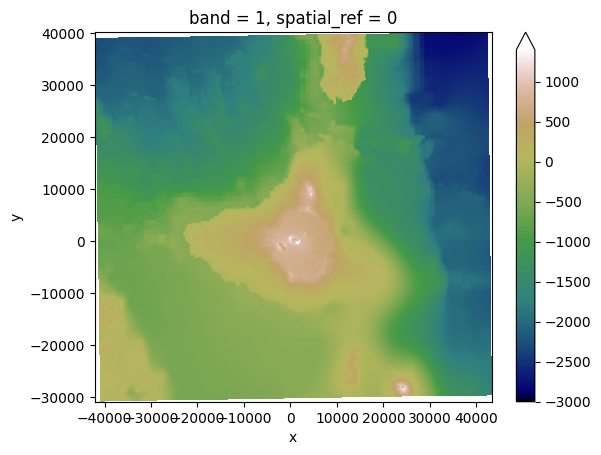

In [5]:
# read unmasked topography
topo_um = rx.open_rasterio('data/Ambrym_unmasked.tif')
# add projection info
topo_um = topo_um.rio.write_crs("EPSG:4326")
# topo max
zmax = int(topo_um.sel(band=1).max())

# convert to UTM
topo_um_utm = topo_um.rio.reproject("epsg:32759")

# recenter the topo
topo_um_utm = topo_um_utm.assign_coords(x=topo_um_utm.x-volcx,y=topo_um_utm.y-volcy)
topo_um_utm.sel(band=1).plot.imshow(cmap='gist_earth',vmin=-3000,vmax=1400)

#### Define Cross-sections for visualization

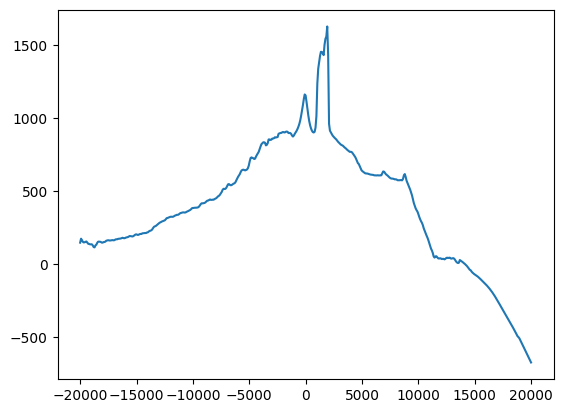

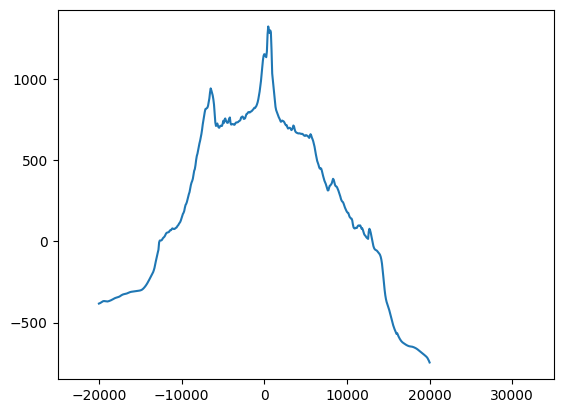

In [6]:
import xarray as xr
# E-W cross-section cut y = 0
x_cuty0 = xr.DataArray(np.linspace(-20e3,20e3,501), dims="z")
y_cuty0 = xr.DataArray(np.zeros(501), dims="z")
z_cuty0 = topo_um_utm.interp(x=x_cuty0, y=y_cuty0)
# N-S cross-section cut x = 0
x_cutx0 = xr.DataArray(np.zeros(501), dims="z")
y_cutx0 = xr.DataArray(np.linspace(-20e3,20e3,501), dims="z")
z_cutx0 = topo_um_utm.interp(x=x_cutx0, y=y_cutx0)
# plot
plt.plot(x_cuty0,z_cuty0[0],'-')
plt.show()
plt.plot(y_cutx0,z_cutx0[0],'-')
plt.xlim(-25e3,35e3)
plt.show()

In [8]:
# Make two points to construct the line between
line_p0 = [-9.9e3,2e3,0]
line_p1 = [8.2e3,-2e3,0]


# read topography
topo = read_geotiff('data/Ambrym_masked.tif',
                    LL2UTM, center=[volcx, volcy],dinv=2)

best_topo = []
erro_topo = []
data_topo = []
for track in [0,1]:
    # get data
    topo_copy = topo.copy()
    topo_copy.clear_data()
    topo_copy = topo_copy.interpolate(pv_AD[track]['unif_point'],radius=150,
                                      strategy='null_value',null_value=np.nan)
    topo_copy.points[:,2] = topo['data'] * 1.
    #topo_copy.points[topo['data']<1,2] = np.nan
    data_topo.append(topo_copy)

#  create a cutplane for showing the profile location 
cutplane = pv.Plane(center=[(line_p0[0]+line_p1[0])/2,
                            (line_p0[1]+line_p1[1])/2,0],
                    direction=[-line_p0[1]+line_p1[1],line_p0[0]-line_p1[0],0],
                    i_size=np.sqrt((line_p0[1]-line_p1[1])**2+(line_p0[0]-line_p1[0])**2)/3,
                    j_size=np.sqrt((line_p0[1]-line_p1[1])**2+(line_p0[0]-line_p1[0])**2),
                   )

In [13]:
# plot the InSAR deformation on the topography
# plot the location of the cross_section
Astep = 169
Dstep = 87
cmax = 0.8

# make plots via pyVista
pl5 = pv.Plotter(shape=(1, 2))

# plot a clippered 3D plot
pl5.subplot(0, 0)
pl5.add_title('{} {}'.format(track_label[0], pv_AD[0]['time'][Astep].date()))
pl5.add_mesh(data_topo[0], scalars='t{}'.format(Astep),cmap="RdBu_r",clim=[-cmax,cmax])
pl5.add_mesh(cutplane, color="k")

pl5.subplot(0, 1)
pl5.add_title('{} {}'.format(track_label[1], pv_AD[1]['time'][Dstep].date()))
pl5.add_mesh(data_topo[1], scalars='t{}'.format(Dstep),cmap="RdBu_r",clim=[-cmax,cmax])
pl5.add_mesh(cutplane, color="k")

pl5.link_views()
pl5.set_background('k')
pl5.screenshot('figures/InSAR_A{}D{}.png'.format(Astep,Dstep),window_size=[4000,2000])
pl5.show_grid(color='k')
pl5.show()


In [21]:
### read the deformation of two points which mostly experiencing 
# pure uplift or subsidence
# read data
UP_ts2 = np.loadtxt('data/uplift_-16.2244_168.0734_updated.txt',delimiter=',')
SU_ts2 = np.loadtxt('data/subsidence_-16.2497_168.133_updated.txt',delimiter=',')
dt_ts2 = np.loadtxt('data/updatedDates_asc.txt')
# combine data to a spreadsheet
dt_ts2 = pd.to_datetime(dt_ts2,format='%Y%m%d')
TS2 = {'t':dt_ts2, 'sub':SU_ts2, 'upl':UP_ts2}
TS2 = pd.DataFrame(TS2)
TS2['day'] = (TS2.t-TS2.t[0]).values.astype(int)/1e9/3600/24.
TS2

t    sub    upl     day
0   2018-12-19   3.50   6.76     0.0
1   2018-12-25   2.82   2.34     6.0
2   2018-12-31   1.35  -1.28    12.0
3   2019-01-06   0.00   0.00    18.0
4   2019-01-12  -1.52  -0.62    24.0
..         ...    ...    ...     ...
179 2022-01-14 -16.02  12.45  1122.0
180 2022-01-26 -15.94  12.03  1134.0
181 2022-02-07 -13.92  12.25  1146.0
182 2022-02-19 -14.61  15.53  1158.0
183 2022-03-03 -16.00  12.65  1170.0

[184 rows x 4 columns]

### Assuming the inflation and deflation fuctions

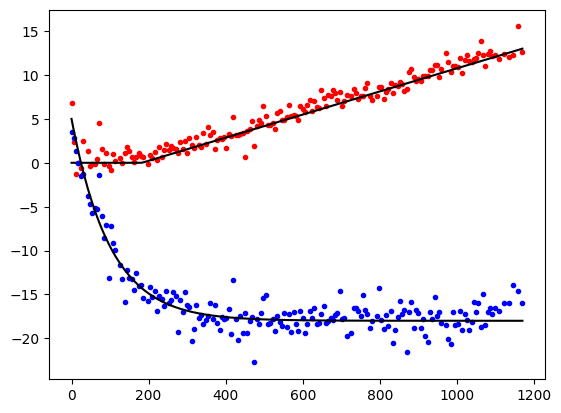

In [23]:
# define loading functions
def P_inflation(day, start_year=1):
    k = start_year * 365.25
    P = np.zeros(len(day))
    P[day>k] = (day[day>k] - k) / (day.max()-k)
    return P

def P_deflation(day, decay_coef=-2):
    return np.exp(-day*(10**decay_coef)) - 1

plt.plot(TS2['day'], TS2['upl'],'r.')
plt.plot(TS2['day'],P_inflation(TS2['day'], start_year=0.5)*13,'k-')

plt.plot(TS2['day'], TS2['sub'],'b.')
plt.plot(TS2['day'],P_deflation(TS2['day'], decay_coef=-2)*23+5,'k-')

### Construct the dataset for EnKF

In [24]:
# days from the starting date 
day_all = ((time_all - time_all[0])/1e9/3600/24.).astype(float)
day_asc = (pv_asc['time'] - time_all[0]).days.astype(float)
day_des = (pv_des['time'] - time_all[0]).days.astype(float)
day_AD = [day_asc, day_des]

# allocate the arrays for data
# data coordinates
enkf_AD_x = np.array([])
enkf_AD_y = np.array([])
# InSAR looking angle
enkf_AD_lkx = np.array([])
enkf_AD_lky = np.array([])
enkf_AD_lkz = np.array([])
# number of data points
ndat_AD = np.array([])
# reference points index
ref_id_AD = np.array([])
# data point from which track
track_identifier = []

# for both ascending and descending
for track in [0,1]:
    # Nan Value
    Inan = np.isnan(pv_AD[track]['unif_point']['t0'])
    # x and y
    enkf_x = np.array(pv_AD[track]['unif_point'].points[~Inan,0])
    enkf_y = np.array(pv_AD[track]['unif_point'].points[~Inan,1])
    # number of the data
    ndat_AD = np.hstack([ndat_AD, len(enkf_x)])
    # ensemble all tracks
    enkf_AD_x = np.hstack([enkf_AD_x, enkf_x])
    enkf_AD_y = np.hstack([enkf_AD_y, enkf_y])
    # looking angle
    enkf_AD_lkx = np.hstack([enkf_AD_lkx, np.array(pv_AD[track]['unif_point']['lkag_x'][~Inan])])
    enkf_AD_lky = np.hstack([enkf_AD_lky, np.array(pv_AD[track]['unif_point']['lkag_y'][~Inan])])
    enkf_AD_lkz = np.hstack([enkf_AD_lkz, np.array(pv_AD[track]['unif_point']['lkag_z'][~Inan])])
    # track identifier
    track_identifier.append(np.ones(len(enkf_x))*track)
    # referece id
    ref_id_AD = np.hstack([ref_id_AD, int(np.argmin((enkf_x-ref_x[track])**2+(enkf_y-ref_y[track])**2))])

track_identifier = np.hstack(track_identifier)
    
# construct all data array
enkf_dat_all = []
dat_identifier = []
for iday, day in enumerate(day_all):
    # find which track is used
    for track in [0,1]:
        if day in day_AD[track]:
            # Nan Value
            Inan = np.isnan(pv_AD[track]['unif_point']['t0'])
            # find t id
            t_id = np.where(day_AD[track]==day)[0][0]
            dat_cur = pv_AD[track]['unif_point']['t{}'.format(t_id)][~Inan] * 1.
            enkf_dat_all.append(dat_cur)
            dat_identifier.append(np.ones(len(dat_cur))*(track*1000+t_id))
            
enkf_dat_all = np.hstack(enkf_dat_all)
dat_identifier = np.hstack(dat_identifier)


### Parameters for EnKF

In [27]:
# number of ensemble (at least 100, 
# but use small number first to test the workflow)
nens = 200
# number of iteration
niter = 20
# number of steps
nstep = 1
# number of the chambers
ncham = 2
# Error coefficient
ecoef = 0.01
# initial distribution
ini_dis = 'normal'

# model name
modelname = 'N{}I{}Nc{}Ec{}_EnTS_AD'.format(nens,niter,ncham,int(ecoef*10))
# data path
datapath = 'results/{}'.format(modelname)
# create data path
os.system('mkdir {}'.format(datapath))

0

### Intial parameters

In [28]:
# parameter names and units
pname = ['x', 'y', 'z', 'r1', 'r2/r1','$\\theta$', '$\phi$','A','B']
# parameter units
punit = ['km', 'km', 'km', 'km', '1', 'rad', 'rad','MPa','yr']
## Different initial guess for different sources
# initial parameter range for source 1 inflation
prange_1 = np.vstack([[-5,5],
                      [-5,5],
                      [-8,-2],
                      [0.1,5],
                      [0.1,5],
                      [0,np.pi/2],
                      [1.2*np.pi,2*np.pi],
                      [0,100],
                      [0,1]
                     ])
# initial parameter range for source 2 deflation
prange_2 = np.vstack([[0,10],
                      [-5,5],
                      [-8,-2],
                      [0.1,5],
                      [0.1,5],
                      [-np.pi/2,np.pi/2],
                      [0,2*np.pi],
                      [0,100],
                      [-3,-1]
                     ])

prange = [prange_1,prange_2]

# number of parmeters
npar = len(pname)

# save initial information
enkf_par = {'nens':nens, 'niter':niter, 'nstep':nstep, 'ncham':ncham, 'ecoef':ecoef,
            'pname':pname, 'punit':punit, 'prange':prange
           }
with open('{}/enkf_par.pkl'.format(datapath), 'wb') as tf:
    pickle.dump(enkf_par, tf)

### Generate Initial Ensemble & Make a plot

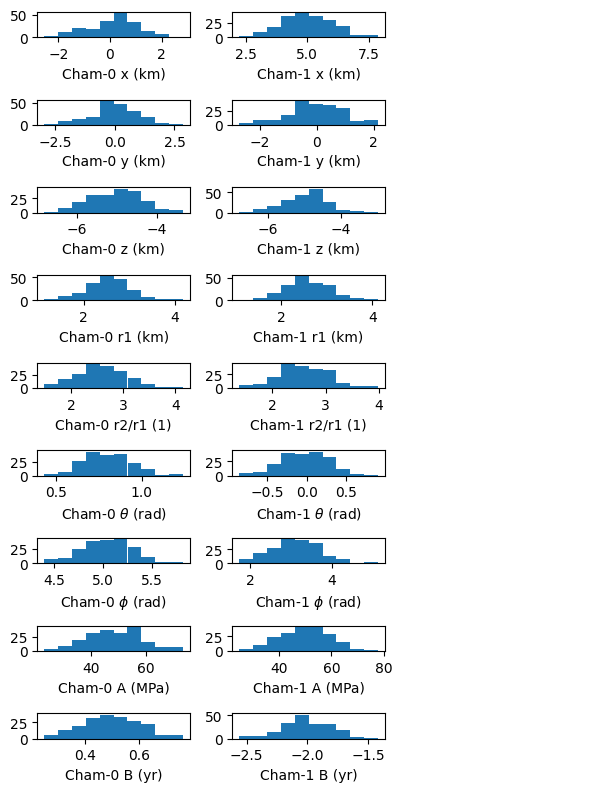

In [29]:
# generate normalized parameter space [0,1]
if ini_dis=='uniform':
    A_EnKF_p = np.random.uniform(0,1,size=[npar*ncham,nens])
elif ini_dis=='normal':
    A_EnKF_p = np.random.normal(0.5,0.1,size=[npar*ncham,nens])
else:
    raise ValueError('invalid: ini_dis')

# plot initial distribution
fig, axs = plt.subplots(npar,ncham+1,figsize=(6,8))
for cham in range(0, ncham):
    for p in range(0, npar):
        axs[p,cham].hist(A_EnKF_p[p+npar*cham,:]*(prange[cham][p,1]-prange[cham][p,0])+prange[cham][p,0])
        axs[p,cham].set_xlabel('Cham-{} {} ({})'.format(cham, pname[p], punit[p]))

for ax in axs[:,ncham]:
    ax.set_axis_off()

plt.tight_layout()
fig.savefig('{}/Initial_param.pdf'.format(datapath))
plt.show()

### Running the EnKF

In [30]:
import random
from util.enkf import genetic

### Run EnKF
# allocate the results matrix
A_res = []
# allocate the root mean square error
RMSE = np.zeros([niter, nens])
# allocate the parameter estimation
param_est = np.zeros([npar*ncham, nens, niter+1])
# storing the initial parameter
param_est[:, :, 0] = A_EnKF_p * 1.
# for update print
print_screen = sys.stdout

# update time
t0 = time.time()

# for each iterations
for iteration in range(0, niter):

    # allocate source results
    LOS_InDe = []
    for cham in range(0, ncham):
        # allocate real parameters for this chamber
        RP = np.zeros([npar, nens])
        # get real parameters
        for p in range(0, npar):
            RP[p,:] = A_EnKF_p[p+npar*cham,:]*(prange[cham][p,1]-prange[cham][p,0])+prange[cham][p,0]
            # get real loading coeff. 
            if p==8:
                if cham==0:
                    start_year = RP[p,:] * 1.
                elif cham==1:
                    decay_coef = RP[p,:] * 1.

        # allocate a list for all arguments for "yang_disp_pool" function
        arg_yang_disp_pool = []
        for n in range(0, nens):
            # append to the arguments
            arg_yang_disp_pool.append([enkf_AD_x, enkf_AD_y,RP[:,n]])

        # solve the Yang model
        if __name__ ==  '__main__': 
            p=Pool(processes=PROCESSES)
            output = p.starmap(yang_disp_pool, arg_yang_disp_pool)
        # add the displacement from current chamber
        disp_cham = np.array(output)

        # LOS raw (displacement in the direction of looking angle)
        LOS_raw = (+disp_cham[:,0,:] * enkf_AD_lkx
                   +disp_cham[:,1,:] * enkf_AD_lky
                   +disp_cham[:,2,:] * enkf_AD_lkz)
        
        # calcuate reference disp
        LOS_ref = np.zeros([int(np.sum(ndat_AD)),nens])
        for track in [0,1]:
            itrack = (track_identifier==track)
            LOS_raw_cur = LOS_raw[:,itrack] * 1.
            track_ref = np.tile(LOS_raw_cur[:,int(ref_id_AD[track])], (int(ndat_AD[track]),1))
            LOS_ref[itrack] = track_ref * 1.
            
        # Relative LOS to the reference
        LOS_model = LOS_raw.T - LOS_ref

        # get P_coeff timeseries for each ensemble
        P_coeff_nens = np.zeros([len(day_all),nens])
        for n in range(0, nens):
            # (1) Inflation
            if cham==0:
                P_coeff = P_inflation(day_all, start_year=start_year[n])
            # (2) Deflation
            if cham==1:
                P_coeff = P_deflation(day_all, decay_coef=decay_coef[n])
            # assemble all ensembles
            P_coeff_nens[:,n] = P_coeff * 1.

        ALL_LOS = []
        # for all time slices
        for iday, day in enumerate(day_all):
            # get data for current track
            for track in [0,1]:
                if day in day_AD[track]:
                    itrack = (track_identifier==track)
                    LOS_model_track = LOS_model[itrack,:] * 1.

            # get current P_coeff.
            P_coeff_nens_tile = np.tile(P_coeff_nens[iday,:],(LOS_model_track.shape[0],1))
            # calculate current P-loading results
            CUR_LOS = LOS_model_track * P_coeff_nens_tile
            ALL_LOS.append(CUR_LOS)

        #LOS_cham[cham] = LOS_model * 1.
        LOS_InDe.append(np.vstack(ALL_LOS))
    # sum two sources
    LOS_SUM = LOS_InDe[0] + LOS_InDe[1]

    # shrink the data size
    n_shrink = int(len(enkf_dat_all)/50)
    i_shrink = random.choices(range(0,len(enkf_dat_all)), k=n_shrink)
    i_shrink.sort()

    # Update A matrix
    A = np.vstack([A_EnKF_p, LOS_SUM[i_shrink,:]])

    # EnKF analysis
    # error coefficient
    A = EnKF(A, enkf_dat_all[i_shrink], e_coef=ecoef, dnorm=False)

    # calculate L2 norm
    L2 = genetic.L2norm(A, enkf_dat_all[i_shrink])
    Imut, L2mean = genetic.L2findMutation(L2, 0.9)
    A = genetic.Mutation(A, Imut, A.std(1))

    # get updated parameters
    A_EnKF_p = A[0:npar*ncham,:] * 1.

    # storing Root Mean Square Error (L2)
    RMSE[iteration, :] = L2 * 1.
    # store the parameter estimation
    param_est[:, :, iteration+1] = A_EnKF_p * 1
    
    # Calculate time remaining
    dtime = time.time()-t0
    time_per_iter = dtime / (iteration+1)
    time_remaining = time_per_iter * (niter-iteration)
    print_screen.write('\r {} [{:.1f}%] I{} | ErrCoef={:.2f}'\
                       ' | L2={:.3f} | Time per iter={:.2f}s'\
                       ' | Time remaining={}:{:.1f}'\
                       ''.format(modelname,(iteration+1)/niter*100,iteration,ecoef,L2.mean(),
                                 time_per_iter,int(time_remaining/60),time_remaining%60,)
                      )
    print_screen.flush()
    
print('DONE!')

 N200I20Nc2Ec0_EnTS_AD [100.0%] I19 | ErrCoef=0.01 | L2=6.989 | Time per iter=22.78s | Time remaining=0:22.8

### Plot overall performance

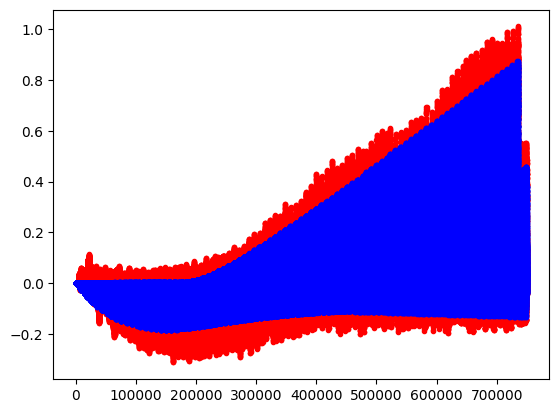

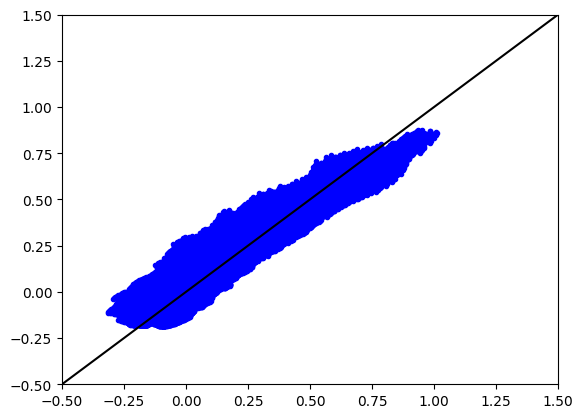

In [31]:
plt.plot(enkf_dat_all,'r.')
plt.plot(LOS_SUM.mean(1),'b.')
plt.show()

plt.plot(enkf_dat_all,LOS_SUM.mean(1),'b.')
plt.plot([-10,10],[-10,10],'k-')
plt.xlim(-.5,1.5)
plt.ylim(-.5,1.5)
plt.show()

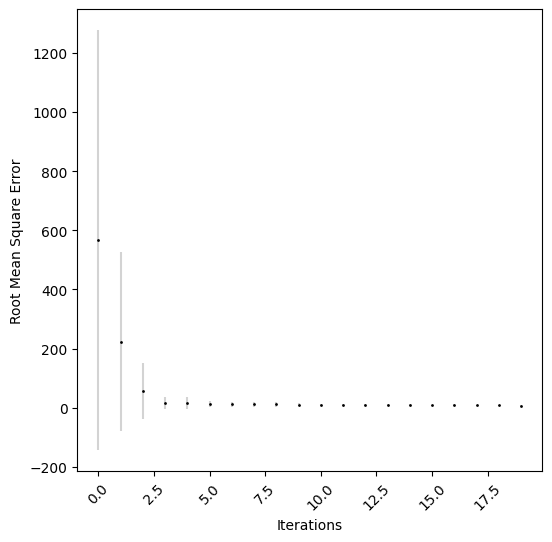

In [32]:
### Plot RMSE 
# iteration array
iter_array = np.arange(0, niter)
# plot
fig = plt.figure(1, figsize=(6,6))
ax = plt.subplot(111)
ax.errorbar(iter_array, RMSE.mean(1), yerr=RMSE.std(1)*2., 
            marker='o',markersize=2,linestyle='none',
            ecolor='lightgrey',markerfacecolor='k',markeredgecolor='none')

ax.set_xlabel('Iterations')
ax.set_ylabel('Root Mean Square Error')
#ax.set_ylim(0,1)
for tick in ax.get_xticklabels():
    tick.set_rotation(45)   
fig.savefig('{}/RMSE.pdf'.format(datapath))


In [33]:
### Save results
# save parameter
np.save('{}/PARA.npy'.format(datapath), param_est)
# save RMSE
np.save('{}/RMSE.npy'.format(datapath), RMSE)

# InSAR LOS def from the last iteration
LOS_avg = LOS_SUM.mean(1)
LOS_std = LOS_SUM.std(1)
# save the deformation results
np.save('{}/LOS_avg.npy'.format(datapath), LOS_avg)
np.save('{}/LOS_std.npy'.format(datapath), LOS_std)

# Create Surface deformation via pyVista
for track in [0,1]:
    for iday, day in enumerate(day_all):
        if day in day_AD[track]:
            # Nan Value
            Inan = np.isnan(pv_AD[track]['unif_point']['t0'])
            # find t id
            t_id = np.where(day_AD[track]==day)[0][0]
            # find results location
            idat = (dat_identifier==track*1000+t_id)
            
            mod_AD[track]['t{}'.format(t_id)] = np.zeros(len(pv_AD[track]['unif_point']['t0'])) * np.nan
            mod_AD[track]['t{}'.format(t_id)][~Inan] = LOS_SUM.mean(1)[idat] * 1.
            # find best
            #ibest = np.argmin(RMSE[step, :])
            #mod_AD[track]['t{}'.format(t_id)][~Inan] = A_res[step][:,ibest] * 1.
    
    # save the data as VTK format
    mod_AD[track].save('{}/MOD_{}.vtk'.format(datapath, track_label[track]))    

## Post-processing & Visualizing the results

### Read the demo results

In [34]:
# model name
modelname = 'demo'

# data path
datapath = 'results/{}'.format(modelname)

# enkf parameters
with open('{}/enkf_par.pkl'.format(datapath), 'rb') as tf:
    enkf_par = pickle.load(tf)

# Read results
param_est = np.load('{}/PARA.npy'.format(datapath))
RMSE = np.load('{}/RMSE.npy'.format(datapath))
LOS_avg = np.load('{}/LOS_avg.npy'.format(datapath))
LOS_std = np.load('{}/LOS_std.npy'.format(datapath))
MOD_Ascending = pv.read('{}/MOD_Ascending.vtk'.format(datapath))
MOD_Descending = pv.read('{}/MOD_Descending.vtk'.format(datapath))
mod_AD = [MOD_Ascending, MOD_Descending]

### Deformation along the cross-section

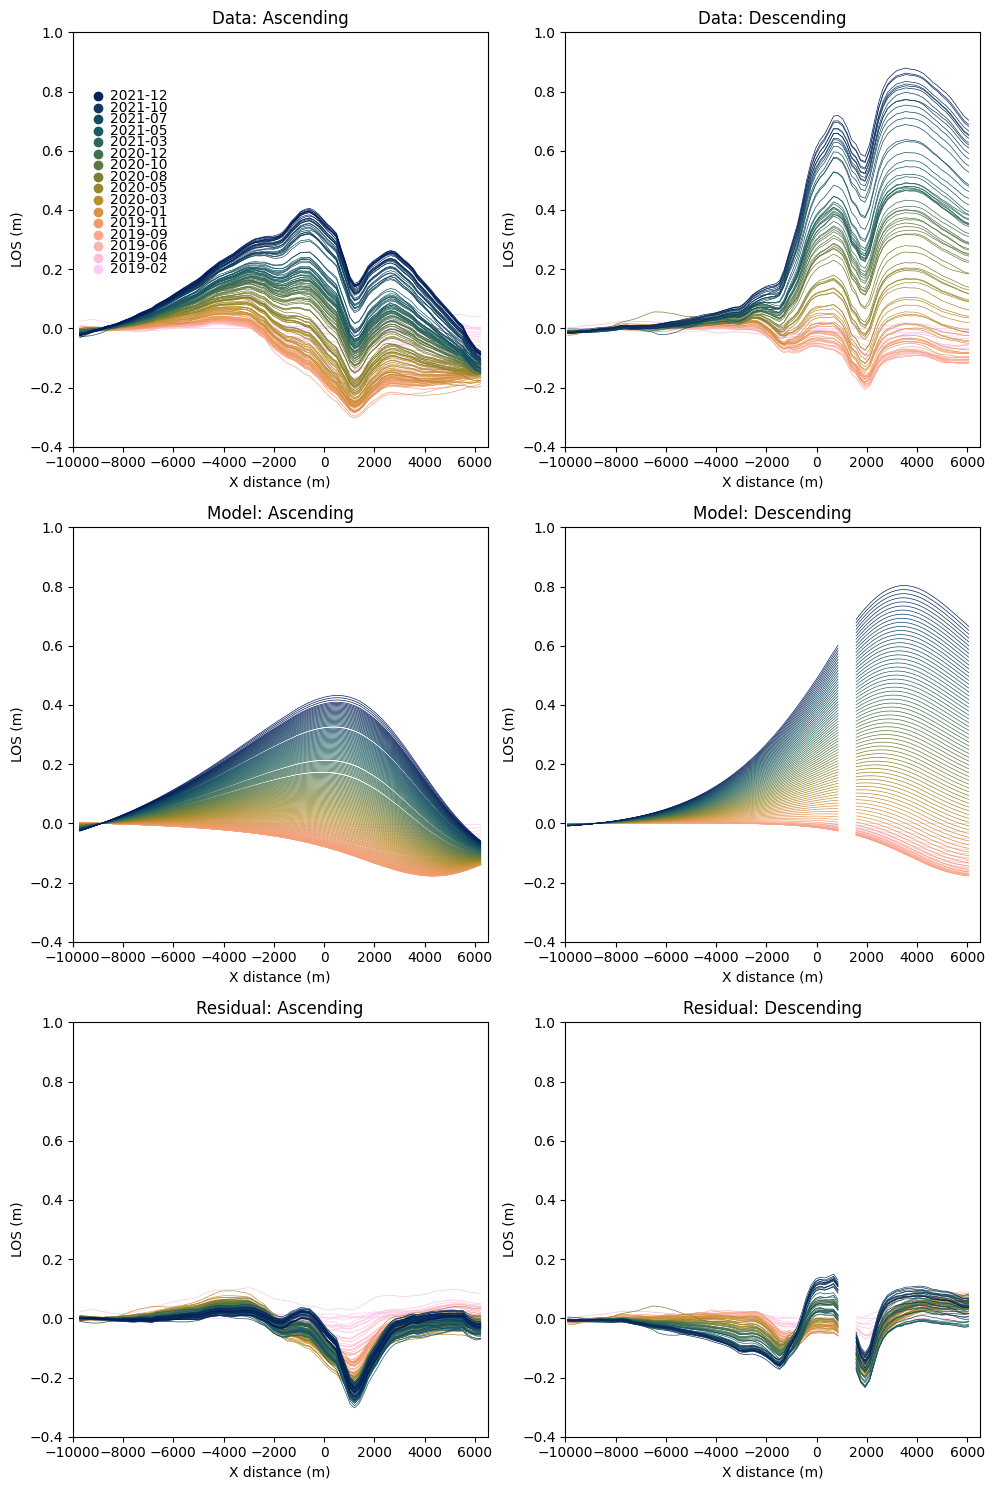

In [37]:
### Plot Crosssections
# create a plane type data
PLmod = []
# size of the interpolation
dsize = 100    
for track in [0,1]:
    plane_mod = pv_AD[track]['plane'].copy()
    plane_mod.clear_data()
    plane_mod = plane_mod.interpolate(mod_AD[track],radius=dsize*1.2,
                                      strategy='null_value',null_value=np.nan)
    PLmod.append(plane_mod)

# Make two points to construct the line between
line_p0 = [-9.9e3,2e3,0]
line_p1 = [8.2e3,-2e3,0]

#line_p0 = [8200,1780,0]
#line_p1 = [0,-5e3,0]

#line_p0 = [1200,4e3,0]
#line_p1 = [-5e3,-5e3,0]

fig, axs = plt.subplots(3,2,figsize=(10,15))

# color map for the plot
cmap = cmcr.batlow_r
#cmap = plt.cm.magma_r
#title label
titlelabel = ['Data','Model','Residual']
for track in [0,1]:
    # sample the data over the lines
    Line_dat = pv_AD[track]['plane'].sample_over_line(line_p0,line_p1,resolution=101)
    Line_mod = PLmod[track].sample_over_line(line_p0,line_p1,resolution=101)
    LineP = [Line_dat, Line_mod]
    for ax_row in [0,1,2]:
        # set the axis
        axs[ax_row,track].set_xlim(-10e3,6.5e3)
        axs[ax_row,track].set_ylim(-0.4,1.0)
        axs[ax_row,track].set_title('{}: {}'.format(titlelabel[ax_row], track_label[track]))
        axs[ax_row,track].set_ylabel('LOS (m)')
        axs[ax_row,track].set_xlabel('X distance (m)')

        for iday, day in enumerate(day_all):
            if day in day_AD[track]:
                # find t id
                t_id = np.where(day_AD[track]==day)[0][0]
                # plot LOS profiles
                if ax_row < 2:
                    axs[ax_row, track].plot(LineP[ax_row].points[:,0],
                                            LineP[ax_row]['t{}'.format(t_id)],
                                            '-',color=cmap(iday/len(day_all)),lw=0.5)
                else:
                    residual = (- LineP[1]['t{}'.format(t_id)] 
                                + LineP[0]['t{}'.format(t_id)])
                    axs[ax_row, track].plot(LineP[0].points[:,0],residual,
                                            '-',color=cmap(iday/len(day_all)),lw=0.5)

for iday in range(0, len(day_all), 17):
    axs[0,0].plot(-9e3,0.2+0.6*iday/len(day_all),'o',color=cmap(iday/len(day_all)))
    axs[0,0].text(-8.5e3,0.2+0.6*iday/len(day_all),str(time_all[iday])[0:7],va='center')

plt.tight_layout()
#plt.show()
fig.savefig('{}/Cross_section.pdf'.format(datapath))

### Pressure & Volume Evolution

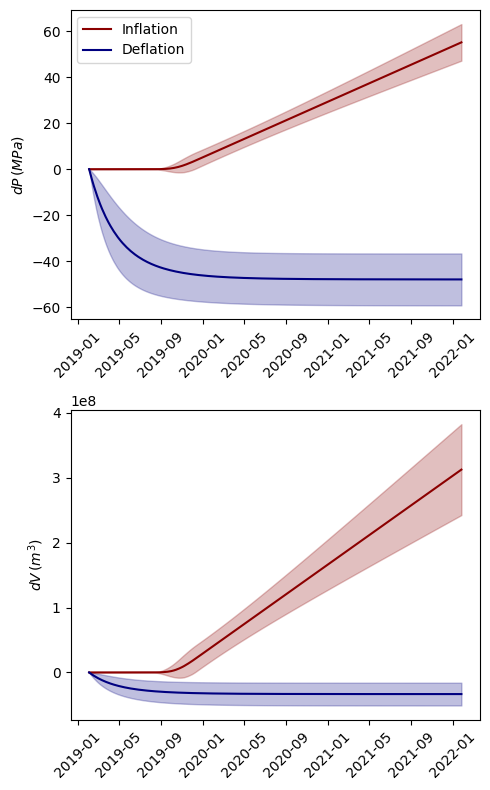

In [38]:
E = 30e9
nu = 0.25
mu = E/2/(1+nu)

mfc = ['darkred','navy','g']
cham_label = ['Inflation','Deflation','Local']
# number of parameters
npar = len(enkf_par['pname'])

fig, ax = plt.subplots(2,1,figsize=(5,8))
# Plot overpressure history
for cham in range(0, enkf_par['ncham']):
    RP = np.zeros([npar, enkf_par['nens']])
    for p in range(0, npar):
        RP[p,:] = (param_est[p+npar*cham,:,-1]*(enkf_par['prange'][cham][p,1]
                                               -enkf_par['prange'][cham][p,0])
                   +enkf_par['prange'][cham][p,0])

    # get P_coeff timeseries for each ensemble
    P_coeff_nens = np.zeros([len(day_all),enkf_par['nens']])
    for n in range(0, enkf_par['nens']):
        # (1) Inflation
        if cham==0:
            P_coeff = P_inflation(day_all, start_year=RP[8,n])*RP[7,n]
        # (2) Deflation
        if cham==1:
            P_coeff = P_deflation(day_all, decay_coef=RP[8,n])*RP[7,n]
        # assemble all ensembles
        P_coeff_nens[:,n] = P_coeff * 1.
        
    ax[0].plot(time_all, P_coeff_nens.mean(1),'-',color=mfc[cham],label=cham_label[cham])
    ax[0].fill_between(x=time_all,
                       y1=P_coeff_nens.mean(1)-P_coeff_nens.std(1)*2,
                       y2=P_coeff_nens.mean(1)+P_coeff_nens.std(1)*2,
                       color=mfc[cham],alpha=0.25
                      )
    
    # calculate volume change
    A = RP[4] * 1.
    V = 4/3*np.pi*RP[3,:]**3*RP[4]**2*1e9
    dVn = V*1e6/mu*(A**2/3-0.7*A+1.37)

    dV = np.tile(dVn, (P_coeff_nens.shape[0],1))
    dV = dV * P_coeff_nens

    ax[1].plot(time_all, dV.mean(1),'-',color=mfc[cham])
    ax[1].fill_between(x=time_all,
                       y1=dV.mean(1)-dV.std(1)*2,
                       y2=dV.mean(1)+dV.std(1)*2,
                       color=mfc[cham],alpha=0.25
                      )
for axc in ax:
    for tick in axc.get_xticklabels():
        tick.set_rotation(45)
ax[0].set_ylabel('$dP\,(MPa)$')        
ax[1].set_ylabel('$dV\,(m^3)$')
ax[0].legend()

plt.tight_layout()
plt.show()
fig.savefig('{}/Overpressure.pdf'.format(datapath))

### Selected LOS contours

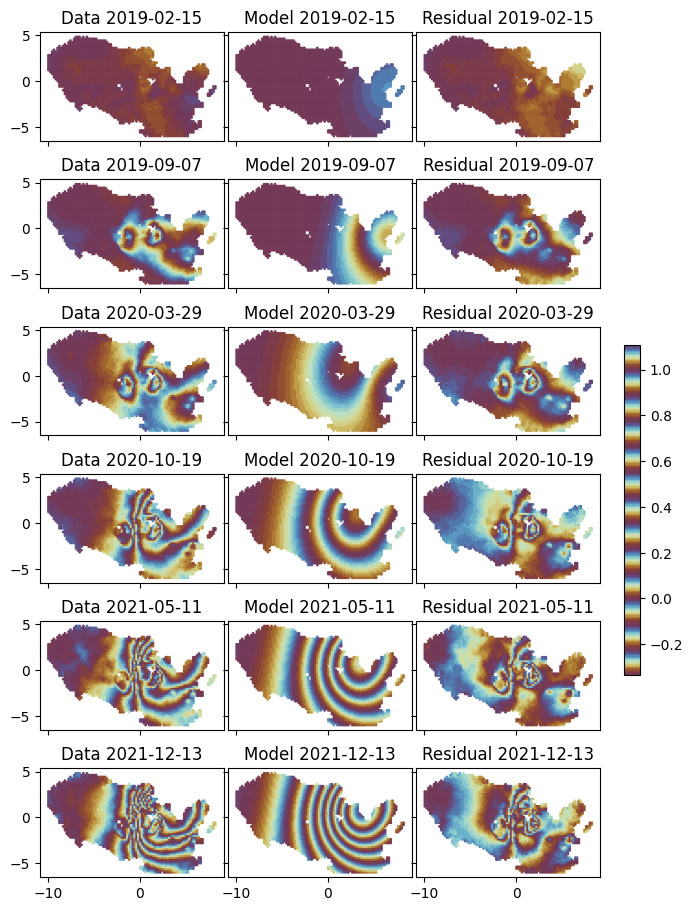

In [39]:
import matplotlib.colors as mcolors

# create colormap
colorfringe = cmcr.romaO(np.linspace(0., 1., 12))
colornew = np.vstack([colorfringe]*13)
insar_cmap = mcolors.LinearSegmentedColormap.from_list('insar', colornew)
# SAR wavelength
sar_wl = 5.5465763e-2
vmin = -sar_wl * 2 * 3
vmax = sar_wl * 2 * 10
levels = np.linspace(vmin,vmax,100)


# number of slice you want to plot
n_slice = 6
track_sel = 1


tlabel = ['Data', 'Model', 'Residual']

# get x and y
dat_x = enkf_AD_x[track_identifier==track_sel] * 1.
dat_y = enkf_AD_y[track_identifier==track_sel] * 1.
# select plot time series
t_id_p = np.linspace(1,len(pv_AD[track_sel]['time'])-1,n_slice).astype(int)
#t_id_p = np.linspace(1,30,n_slice).astype(int)

fig, axs = plt.subplots(n_slice, 3, figsize=(8,11),sharey=True,sharex=True)

for n, t_id in enumerate(t_id_p):
    idat = (dat_identifier==track_sel*1000+t_id)
    # get data and model results
    dat_los = enkf_dat_all[idat] * 1.
    mod_los = LOS_avg[idat] * 1.
    
    # plot
    axs[n,0].scatter(dat_x/1e3, dat_y/1e3, c=dat_los, 
                     s=1, cmap=insar_cmap, vmin=vmin, vmax=vmax,rasterized=True)
    axs[n,1].scatter(dat_x/1e3, dat_y/1e3, c=mod_los, 
                     s=1, cmap=insar_cmap, vmin=vmin, vmax=vmax,rasterized=True)
    st = axs[n,2].scatter(dat_x/1e3, dat_y/1e3, c=dat_los-mod_los, 
                     s=1, cmap=insar_cmap, vmin=vmin, vmax=vmax,rasterized=True)
    
    '''
    #axs[n,0].tricontour(dat_x, dat_y, dat_los, levels=10, linewidths=0.5, colors='k')
    axs[n,0].tricontourf(dat_x, dat_y, dat_los, levels=levels, cmap="Spectral_r")
    axs[n,1].tricontourf(dat_x, dat_y, mod_los, levels=levels, cmap="Spectral_r")
    axs[n,2].tricontourf(dat_x, dat_y, dat_los-mod_los, levels=levels, cmap="Spectral_r")
    '''
    datestr = str(pv_AD[track_sel]['time'][t_id])
    for i in [0,1,2]:
        axs[n,i].set_aspect(1)
        axs[n,i].set_title('{} {}'.format(tlabel[i],datestr[0:10]))


fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
                    wspace=0.025, hspace=0.025)
cb_ax = fig.add_axes([0.83, 0.3, 0.02, 0.3])
cbar = fig.colorbar(st, cax=cb_ax)
fig.savefig('{}/Results_InSAR_{}.pdf'.format(datapath,track_label[track_sel]),dpi=300)    

### Parameters vs. iterations

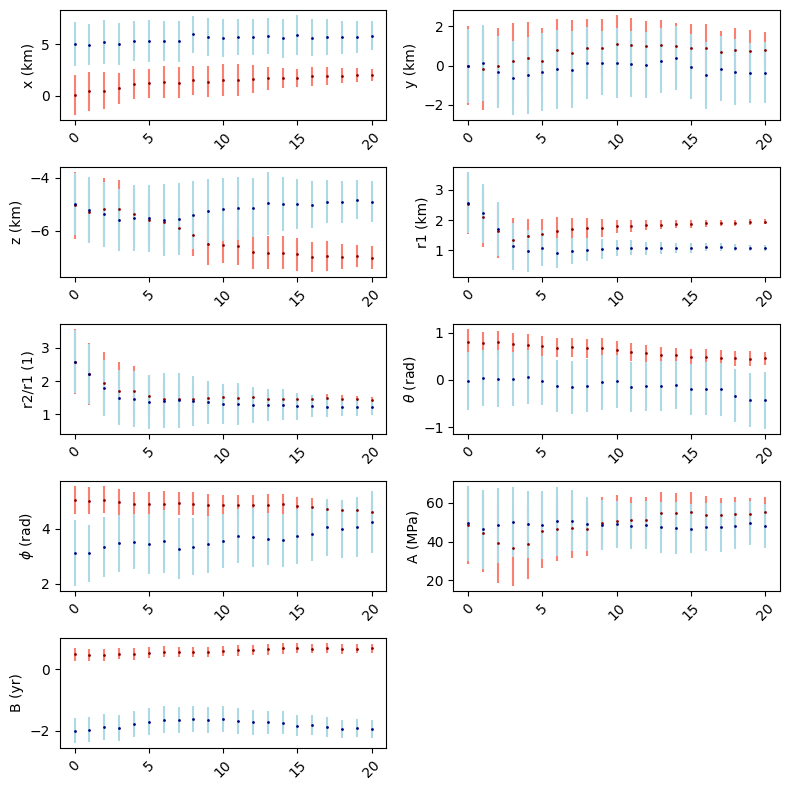

In [40]:
### Plot Parameters
PE_time = np.arange(0, len(time_all)+1)

ebc = ['salmon','lightblue','lightgreen']
mfc = [ 'darkred','navy','g']
cmap_list = ['Reds','Blues','Greens']

iter_array_pe = np.arange(0, niter+1)

fig = plt.figure(1, figsize=(8,8))
# write the parameter of the last step
with open('{}/LastParam.csv'.format(datapath), 'w') as f:
    f.write('symbol,source,mean,two_sigma\n')

    # plot 
    for p in range(0, npar):
        ax = plt.subplot(int(np.ceil(npar/2.)), 2, p+1)
        for cham in range(0,ncham):
            RPplot = param_est[p+npar*cham,:,:]*(enkf_par['prange'][cham][p,1]-
                                                 enkf_par['prange'][cham][p,0])+enkf_par['prange'][cham][p,0]
            ax.errorbar(iter_array_pe, RPplot.mean(0), yerr=RPplot.std(0)*2., 
                        marker='o',markersize=2,linestyle='none',
                        ecolor=ebc[cham],markerfacecolor=mfc[cham],markeredgecolor='none')
            f.write('{},{},{},{}\n'.format(pname[p],cham,RPplot.mean(0)[-1],RPplot.std(0)[-1]*2.))

        ax.set_ylabel('{} ({})'.format(pname[p], punit[p]))
        for tick in ax.get_xticklabels():
            tick.set_rotation(45)  

plt.tight_layout()
fig.savefig('{}/PARAM.pdf'.format(datapath))


### Correlations between parameter pairs

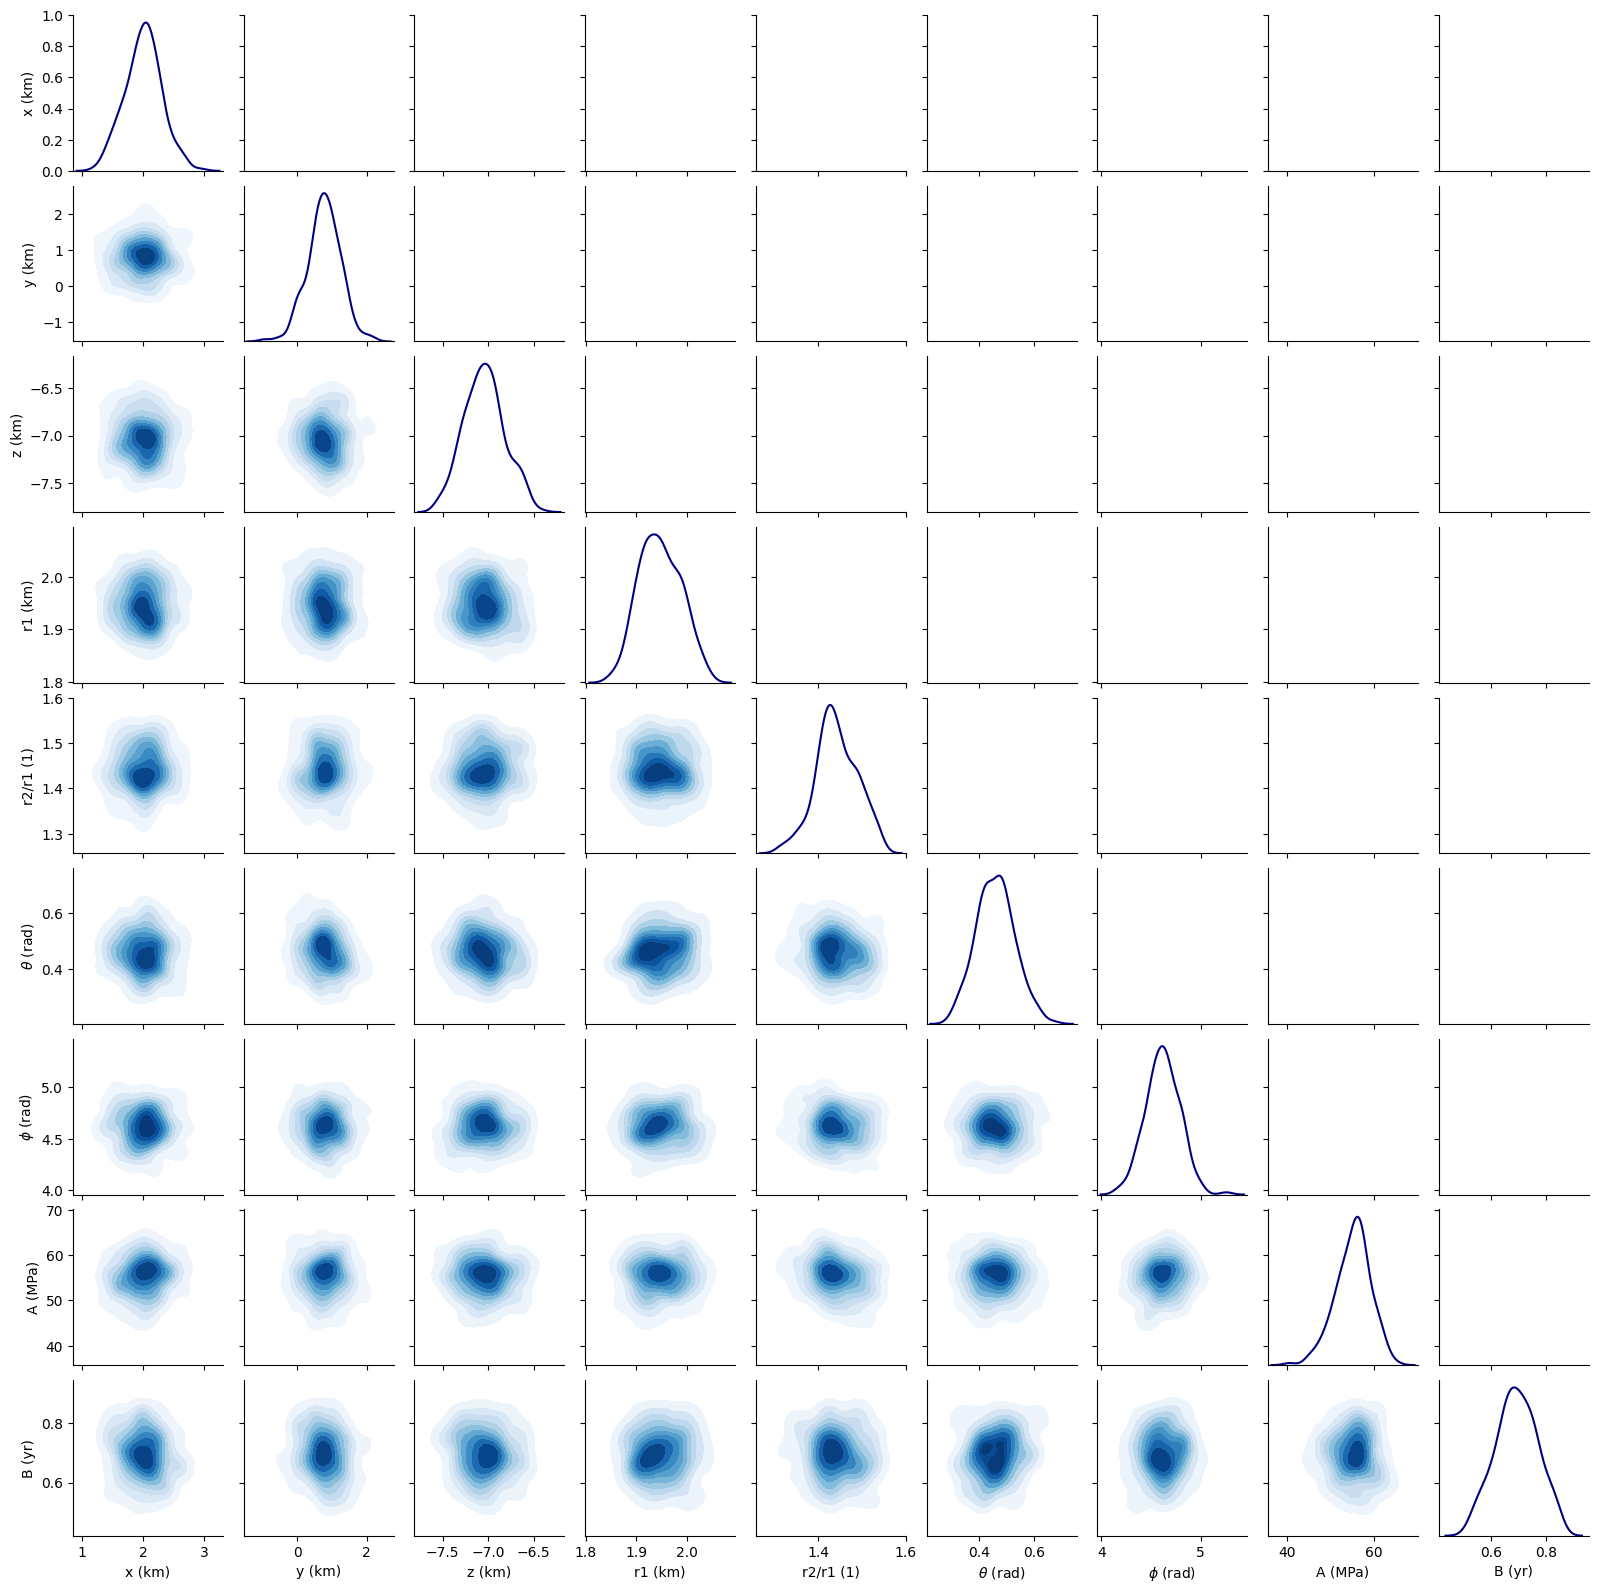

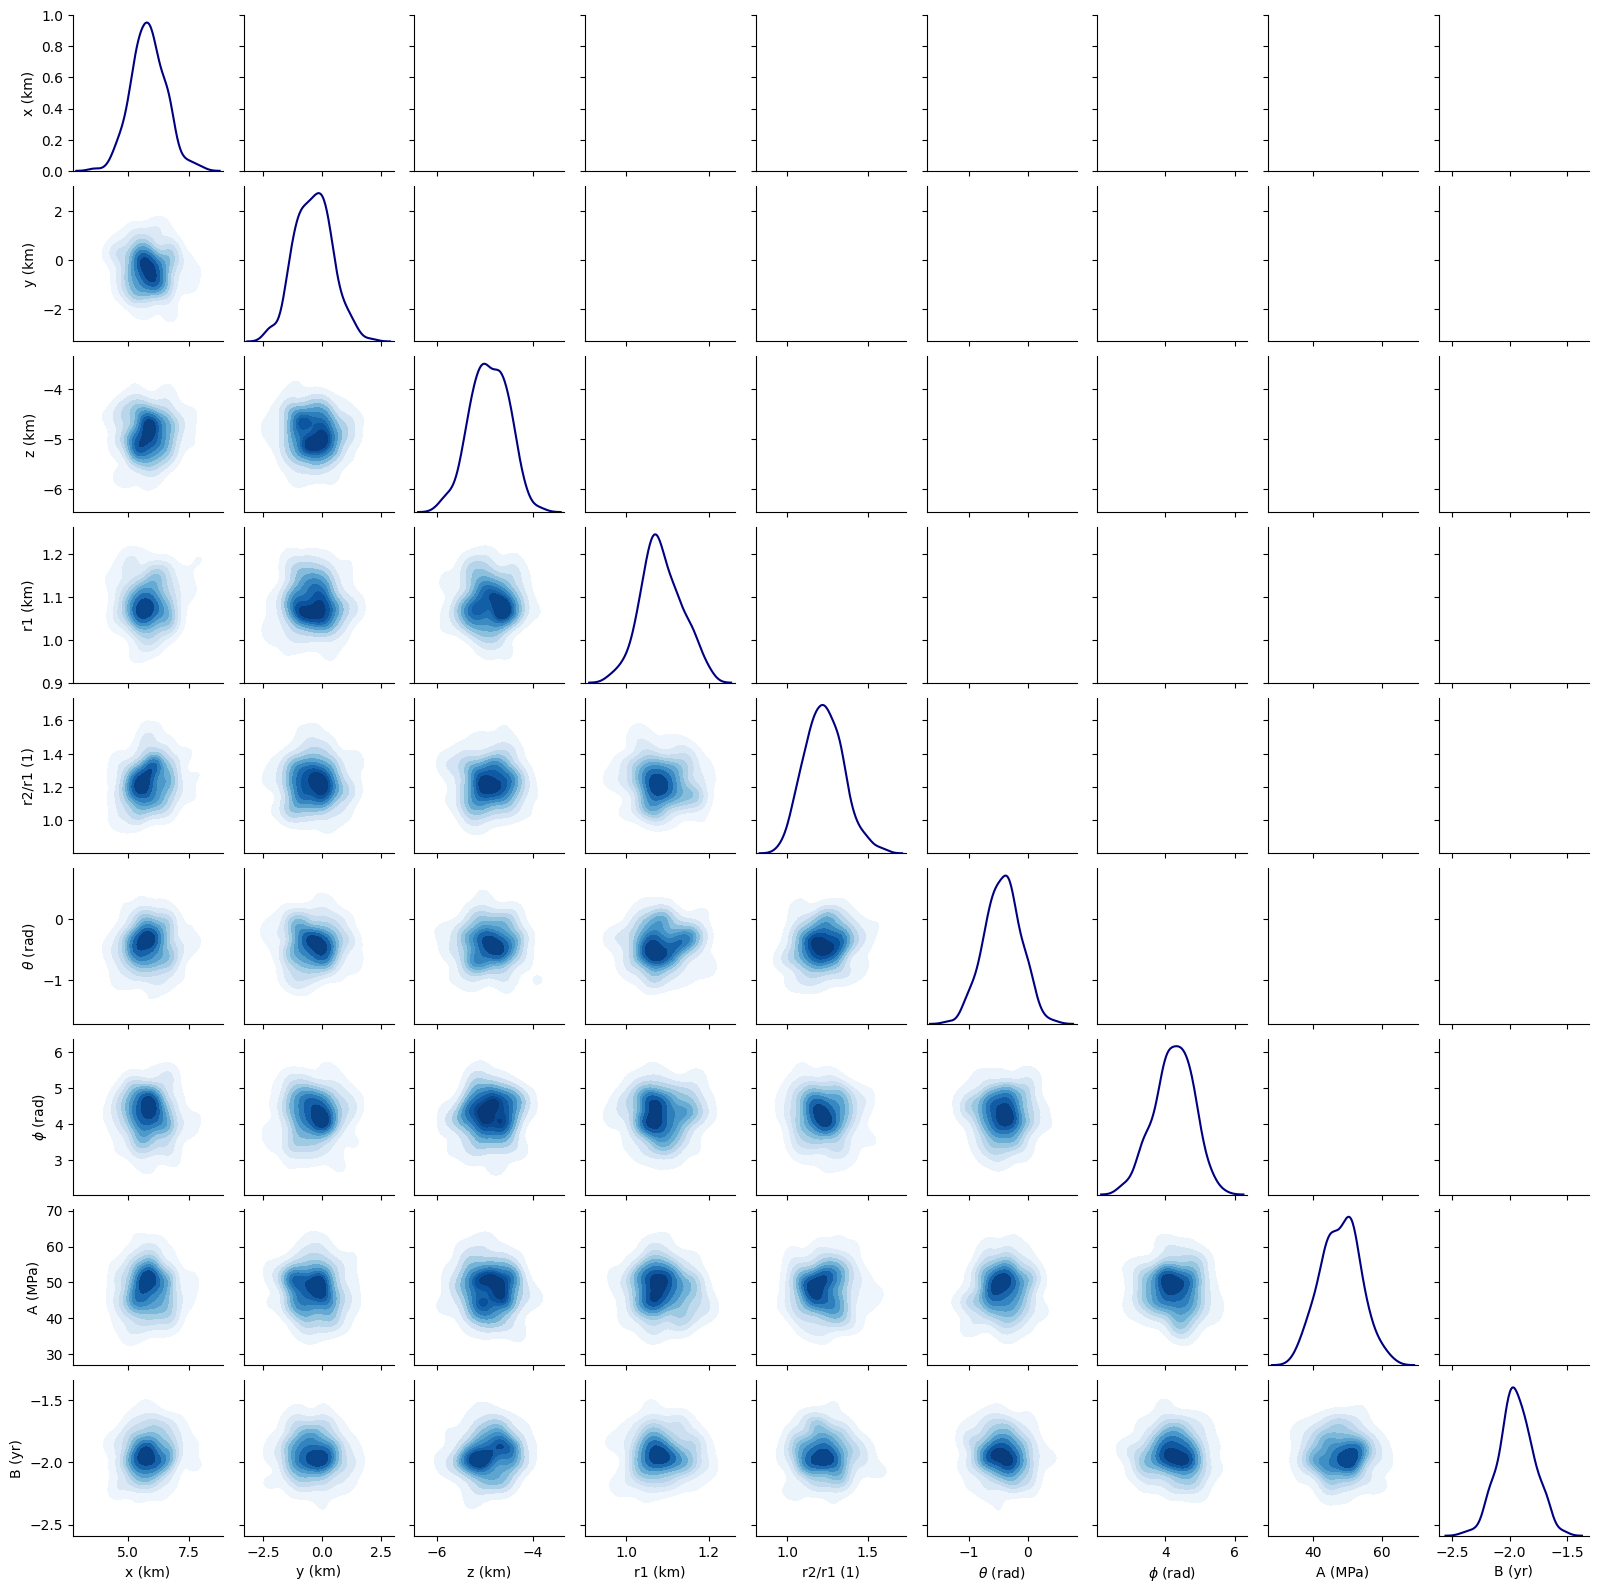

In [41]:
import seaborn as sns

for cham in range(0,ncham):
    RP_last = []
    col_nam = []
    for p in range(0, npar):
        RP_last.append(param_est[p+npar*cham,:,-1]*(enkf_par['prange'][cham][p,1]
                                                    -enkf_par['prange'][cham][p,0])
                       +enkf_par['prange'][cham][p,0])
        col_nam.append('{} ({})'.format(pname[p], punit[p]))
        
    paramplot = pd.DataFrame(np.vstack(RP_last).T)
    paramplot.columns = col_nam
    
    cmap = sns.light_palette("seagreen", as_cmap=True)
    ## plot last step data dataa
    g = sns.PairGrid(paramplot,diag_sharey=False)
    g.map_diag(sns.kdeplot,color='Navy')
    g.map_lower(sns.kdeplot,fill=True,cmap='Blues',levels=10)
    g.add_legend()
    g.fig.set_size_inches(16,16)
    g.fig.savefig('{}/PARAM_pair_s{}.pdf'.format(datapath,cham),pad_inches=0.4)

### Plot density map of deformation sources

In [42]:
### create stacked source projections
from util.postprocess.pvtool import pv_yang_ellipsoid

# resolution: dx=dy=dz=space.
spacing = 100.
# range of the box
Pxmin = -25e3
Pxmax = 25e3
Pymin = -15e3
Pymax = 20e3
Pzmin = -10e3
Pzmax = 2e3
# create 1d arrays for x,y,z
Px1d = np.arange(Pxmin,Pxmax,spacing)
Py1d = np.arange(Pymin,Pymax,spacing)
Pz1d = np.arange(Pzmin,Pzmax,spacing)
# allocate empty arrays along three work planes
PXY_2d = np.zeros([enkf_par['ncham'],len(Py1d),len(Px1d)])
PYZ_2d = np.zeros([enkf_par['ncham'],len(Pz1d),len(Py1d)])
PXZ_2d = np.zeros([enkf_par['ncham'],len(Pz1d),len(Px1d)])
# for all chambers
for cham in range(0, enkf_par['ncham']):
    # for all ensembles
    for n in range(0, enkf_par['nens']):
        # initialize the current work planes
        pxy_2d = np.zeros(PXY_2d[cham].shape)
        pyz_2d = np.zeros(PYZ_2d[cham].shape)
        pxz_2d = np.zeros(PXZ_2d[cham].shape)

        # allocate real parameters for this chamber
        RP = np.zeros(npar)
        # get real parameters
        for p in range(0, npar):
            RP[p] = (param_est[p+npar*cham,n,-1]*(enkf_par['prange'][cham][p,1]
                                                 -enkf_par['prange'][cham][p,0])
                     +enkf_par['prange'][cham][p,0])
        # create an ellipsoid
        ellip = pv_yang_ellipsoid(RP)
        # if the pixel is occupied by the ellipsoid
        Ix = (ellip.points[:,0] - Pxmin)/(Pxmax-Pxmin)*len(Px1d)
        Iy = (ellip.points[:,1] - Pymin)/(Pymax-Pymin)*len(Py1d)
        Iz = (ellip.points[:,2] - Pzmin)/(Pzmax-Pzmin)*len(Pz1d)
        # if the pixel is occupied, then the value is 1/nens
        pxy_2d[Iy.astype('int'),Ix.astype('int')] = 1/enkf_par['nens']
        pyz_2d[Iz.astype('int'),Iy.astype('int')] = 1/enkf_par['nens']
        pxz_2d[Iz.astype('int'),Ix.astype('int')] = 1/enkf_par['nens']
        # update the stacked projections
        PXY_2d[cham] += pxy_2d
        PYZ_2d[cham] += pyz_2d
        PXZ_2d[cham] += pxz_2d

In [43]:
# function for overlaying two images
def overlay(Z1,Z2,vmin=-1.0,vmax=1.0,
            cmap='coolwarm',method='multiply'):
    # get colormap
    ColMap = cm.get_cmap(cmap)
    # RGB of two datasets
    RGB1 = ColMap((Z1-vmin)/(vmax-vmin))
    RGB2 = ColMap((Z2-vmin)/(vmax-vmin))
    # transparent method:
    if method=='multiply':
        RGBT = RGB1 * RGB2
    else:
        raise ValueError("method={} not found".format(method))
        
    return RGBT

In [44]:
# Create the topography
from scipy import interpolate

DEM = topo_utm.data[0] * 1.
DEM[DEM>1e4] =np.nan
Iwater = np.isnan(DEM)
DEM[Iwater] = 0.

f = interpolate.interp2d(topo_utm.x.data, np.flipud(topo_utm.y.data), DEM, kind='linear')
fmask = interpolate.interp2d(topo_utm.x.data, np.flipud(topo_utm.y.data), Iwater, kind='linear')

DEM_new = f(np.arange(Pxmin,Pxmax,spacing),np.arange(Pymin,Pymax,spacing))
mask_new = fmask(np.arange(Pxmin,Pxmax,spacing),np.arange(Pymin,Pymax,spacing))

DEM_new[mask_new > 0] = np.nan

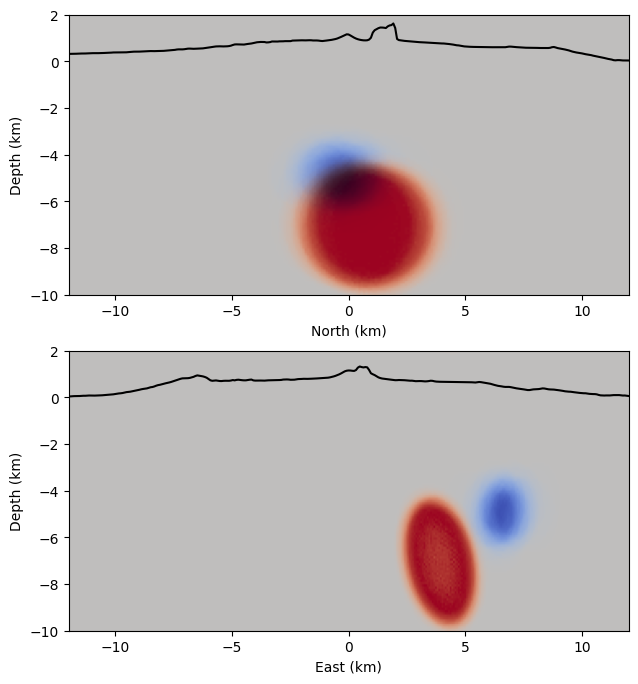

In [45]:
### Cross-sections
fig = plt.figure(1,figsize=(8,8))
ax1 = plt.subplot(211)
DEM_new[DEM_new<0] = np.nan
ax1.imshow(overlay(PYZ_2d[0],-PYZ_2d[1]),
           origin='lower',extent=(Pymin/1e3,Pymax/1e3,Pzmin/1e3,Pzmax/1e3))

# surface topography
ax1.plot(x_cuty0/1e3,z_cuty0[0]/1e3,'k-')

ax1.set_xlim(-12,12)
ax1.set_xlabel('North (km)')
ax1.set_ylabel('Depth (km)')

ax2 = plt.subplot(212)

ax2.imshow(overlay(PXZ_2d[0],-PXZ_2d[1]),
           origin='lower',extent=(Pymin/1e3,Pymax/1e3,Pzmin/1e3,Pzmax/1e3))

# surface topography

ax2.plot(y_cutx0/1e3,z_cutx0[0]/1e3,'k-')

ax2.set_xlim(-12,12)
ax2.set_xlabel('East (km)')
ax2.set_ylabel('Depth (km)')

fig.savefig('{}/source_hist_crosssection.pdf'.format(datapath),dpi=300)

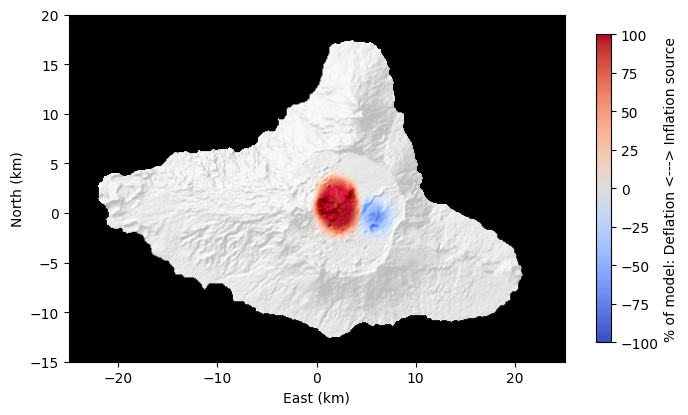

In [46]:
### Map view
from matplotlib.colors import LightSource
import util.postprocess.plttool as plttool
import matplotlib.colors as mcolors

import importlib
importlib.reload(plttool)

#cmap = 'seismic'
cmap = 'coolwarm'

# create the light source
RGB = plttool.shade_data_elev(np.flipud(PXY_2d[0]-PXY_2d[1]), 
                              DEM_new, 1.,dx=spacing,dy=spacing,
                              colormap=cmap,fraction=1, blend_mode='soft', vert_exag=5)

cwater = mcolors.to_rgb('k')
Iwater = np.isnan(RGB[:,:,0])
RGB[Iwater,0] = cwater[0]
RGB[Iwater,1] = cwater[1]
RGB[Iwater,2] = cwater[2]

fig = plt.figure(1,figsize=(8,8))
ax1 = plt.subplot(111)
tcp = ax1.imshow(RGB,
                 extent=(Pxmin/1e3,Pxmax/1e3,Pymin/1e3,Pymax/1e3),
                 cmap=cmap,vmin=-100,vmax=100
                )

cbar = fig.colorbar(tcp, ax=ax1,shrink=0.5)
cbar.set_label('% of model: Deflation <---> Inflation source')
ax1.set_xlabel('East (km)')
ax1.set_ylabel('North (km)')

fig.savefig('{}/source_hist_mapview.pdf'.format(datapath),dpi=300)